In [1]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, precision_recall_curve, auc
from sklearn.utils import class_weight


2023-11-26 01:24:24.255029: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
class FACELoading:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160, 160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()  

    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x, y, w, h = self.detector.detect_faces(img)[0]['box']
        x, y = abs(x), abs(y)
        face = img[y:y + h, x:x + w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr

    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = os.path.join(dir, im_name)
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = os.path.join(self.directory, sub_dir)
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)

    def plot_images(self):
        plt.figure(figsize=(18, 16))
        for num, image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y) // ncols + 1
            plt.subplot(nrows, ncols, num + 1)
            plt.imshow(image)
            plt.axis('off')


In [11]:
# Instantiate FACELoading class
faceloader = FACELoading("dataset")

# Load faces and embeddings
X, Y = faceloader.load_classes()

# Use Facenet for embedding extraction
embedder = FaceNet() 
X_embedded = [embedder.embeddings(img.astype("float32").reshape((1, 160, 160, 3)))[0] for img in X]
X_embedded = np.asarray(X_embedded)
print("Embeddings Shape:", X_embedded.shape)


1/1 [==============================] - 0s 21ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 21ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 24ms/step
Loaded successfully: 7
1/1 [==============================] - 0s 21ms/step
Loaded successfully: 10
1/1 [==============================] - 0s 52ms/step
Embeddings Shape: (37, 512)


In [5]:
# Declare encoder as a global variable
encoder = LabelEncoder()
encoder.fit(Y)
Y_encoded = encoder.transform(Y)

# Train and save model
X_train, X_test, Y_train, Y_test = train_test_split(X_embedded, Y_encoded, shuffle=True, random_state=17)
cosine_model = cosine_similarity(X_train, X_train)
print("Model Trained and Saved")

Model Trained and Saved


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 52ms/step
Prediction Result: seojun


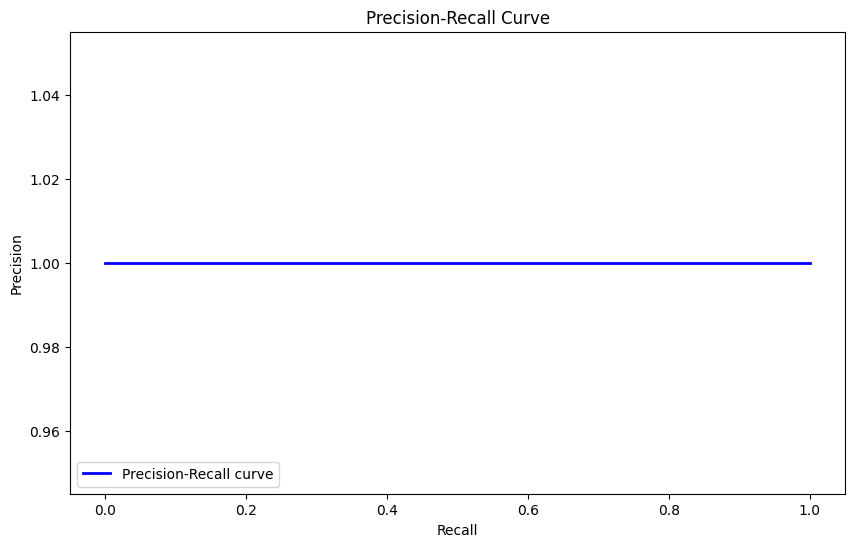

Area Under Curve: 1.0
F1 Score: [1.         0.90909091 0.8        0.66666667 0.5        0.28571429
 0.        ]


In [15]:
# Load model and make predictions
latest_file_path = "../static/assets/DB_img/verification/20231124_174325.jpg"  # Replace with an actual image path
test_img = cv.imread(latest_file_path)
test_img = cv.cvtColor(test_img, cv.COLOR_BGR2RGB)
faces = faceloader.detector.detect_faces(test_img)

if not faces:
    print("Error: No face detected.")
else:
    x, y, w, h = faces[0]["box"]
    test_img = test_img[y : y + h, x : x + w]
    test_img = cv.resize(test_img, (160, 160))
    test_embedding = embedder.embeddings(test_img.astype("float32").reshape((1, 160, 160, 3)))[0]
    similarities = cosine_similarity([test_embedding], X_train)
    predicted_index = np.argmax(similarities)
    
    # Cosine similarity threshold adjustment
    similarity_threshold = 0.8  # Adjust as needed
    similar_faces = np.where(similarities > similarity_threshold)[0]

    if predicted_index < len(encoder.classes_):
        predicted_name = encoder.inverse_transform(np.array([predicted_index]))
        print("Prediction Result:", predicted_name[0])

        # Evaluate the model
        y_true = np.isin(Y_test, Y_encoded)
        y_score = np.max(cosine_similarity(X_test, X_train), axis=1)

        # Precision-Recall curve
        precision, recall, thresholds = precision_recall_curve(y_true, y_score)
        area_under_curve = auc(recall, precision)

        # F1 Score
        f1 = 2 * (precision * recall) / (precision + recall)

        # Plot Precision-Recall curve
        plt.figure(figsize=(10, 6))
        plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()

        print("Area Under Curve:", area_under_curve)
        print("F1 Score:", f1)

In [ ]:
F1 Score: [1.         0.90909091 0.8        0.66666667 0.5        0.28571429
 0.        ]